In [1]:
import os
from os import environ as ENV
ENV['CUDA_VISIBLE_DEVICES'] = '1'
ROOT = ENV['PWD']

from time import time as now
from itertools import combinations
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import scipy
from scipy.special import expit as sigmoid
import jax.numpy as jnp
import jax
import numpy as np
import numpy.typing as npt
Float = np.float64

print(jax.devices())
jax.config.update("jax_enable_x64", True)

import pennylane as qml
dev_cpu = qml.device("lightning.qubit", wires=4)  # CPU faster for 4 qubits
dev_gpu = qml.device("lightning.gpu", wires=18)  # GPU not that much slower, helps with indexing ig?

[cuda(id=0)]


In [2]:
dev_cpu, dev_gpu

(<lightning.qubit device (wires=4) at 0x7f32879b7d10>,
 <lightning.gpu device (wires=18) at 0x7f3190e7fc50>)

In [3]:
# pennylane-catalyst uv/venv metagarbage
import catalyst
# https://github.com/PennyLaneAI/catalyst/pull/1839
# catalyst.utils.runtime_environment.get_cli_path = lambda: ENV['PWD'] + '/.venv/bin/catalyst'
catalyst.utils.runtime_environment.get_cli_path()

'/home/user/work/quadrigems/.venv/bin/catalyst'

In [4]:
import sys
sys.path.append('..')

from circuit_postprocess import *
from should_be_stdlib import *
from neurodata import *
from circuits import *

In [5]:
circuit_iqft     = executor(dev_gpu)(circuit_angle_iqft_swap)
circuit_qft      = executor(dev_gpu)(circuit_angle_qft_swap )
circuit_iqp_qft  = executor(dev_gpu)(circuit_iqp_qft_swap   )
circuit_iqp_iqft = executor(dev_gpu)(circuit_iqp_iqft_swap  )
circuit_amp      = executor(dev_cpu)(circuit_amp_iamp       )
circuit_amp_qft  = executor(dev_cpu)(circuit_amp_iamp_qft   )

In [6]:
def rescale(x):
    #return sigmoid(x / np.linalg.norm(x, ord=1)) * np.pi/2
    return x / np.linalg.norm(x, ord=1) * np.pi/2

def get_fidelity_call(data1:list[int], data2:list[int], circuit) -> tuple[Float,Float]:
    probs = circuit(data1, data2)
    _, fidelity = swap_expectation(probs, len(data1))
    # mean = np.mean(np.array(probs)) # circuit exp value?
    return fidelity, probs

def get_fidelity(data1:list[int], data2:list[int], circuit) -> tuple[Float,Float]:
    # data1 should be less than data2
    if is_array_lesser(data2, data1):
        return get_fidelity(data2, data1, circuit)
    # normalize data
    data1 = rescale(data1)
    data2 = rescale(data2)
    # print(data1 == data2)
    return get_fidelity_call(data1, data2, circuit)

def get_fidelity_amp_call(data1:list[int], data2:list[int], circuit) -> tuple[Float,Float]:
    probs = circuit(data1, data2)
    # fidelity = prob of 0 state
    fidelity = probs[0]
    # mean = np.mean(np.array(probs)) # circuit exp value?
    return fidelity, probs

def get_fidelity_amp(data1:list[int], data2:list[int], circuit) -> tuple[Float,Float]:
    # data1 should be less than data2
    if is_array_lesser(data2, data1):
        return get_fidelity_amp_call(data2, data1, circuit)
    # normalize data
    data1 = rescale(data1)
    data2 = rescale(data2)
    # print(data1 == data2)
    return get_fidelity_amp_call(data1, data2, circuit)

In [7]:
# should get 1
a = np.array(list(range(16)), dtype=Float)
c = np.array(list(range(16)), dtype=Float)

# 18 qubit inputs
b = np.array(list(range(18)), dtype=Float)
d = np.array(list(range(18)), dtype=Float)
#normalization will make these equal to each other

Drawing
0: ──H─╭|Ψ⟩──H─╭|Ψ⟩─╭|Ψ⟩†──H─╭|Ψ⟩†──H─┤ ╭Probs
1: ──H─├|Ψ⟩──H─├|Ψ⟩─├|Ψ⟩†──H─├|Ψ⟩†──H─┤ ├Probs
2: ──H─├|Ψ⟩──H─├|Ψ⟩─├|Ψ⟩†──H─├|Ψ⟩†──H─┤ ├Probs
3: ──H─╰|Ψ⟩──H─╰|Ψ⟩─╰|Ψ⟩†──H─╰|Ψ⟩†──H─┤ ╰Probs
Expanded
(<Figure size 1100x500 with 1 Axes>, <Axes: >)


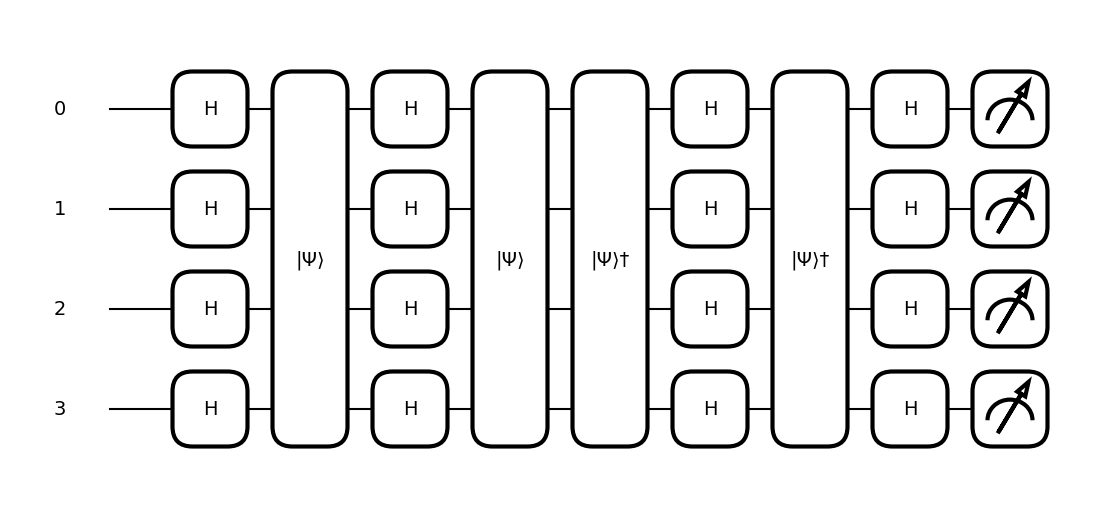

In [8]:
print('Drawing')
print(qml.draw(circuit_amp)(rescale(a), rescale(c)))
print('Expanded')
print(qml.draw_mpl(circuit_amp, level='user')(rescale(a), rescale(c)))

Drawing
0: ──H─╭|Ψ⟩─╭QFT──H─╭|Ψ⟩─╭|Ψ⟩†──H─╭QFT†─╭|Ψ⟩†──H─┤ ╭Probs
1: ──H─├|Ψ⟩─├QFT──H─├|Ψ⟩─├|Ψ⟩†──H─├QFT†─├|Ψ⟩†──H─┤ ├Probs
2: ──H─├|Ψ⟩─├QFT──H─├|Ψ⟩─├|Ψ⟩†──H─├QFT†─├|Ψ⟩†──H─┤ ├Probs
3: ──H─╰|Ψ⟩─╰QFT──H─╰|Ψ⟩─╰|Ψ⟩†──H─╰QFT†─╰|Ψ⟩†──H─┤ ╰Probs
Expanded
(<Figure size 13500x500 with 1 Axes>, <Axes: >)


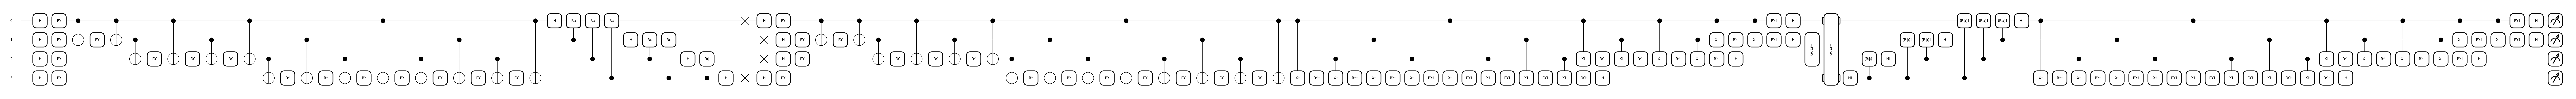

In [9]:
print('Drawing')
print(qml.draw(circuit_amp_qft)(rescale(a), rescale(c)))
print('Expanded')
print(qml.draw_mpl(circuit_amp_qft, level='device')(rescale(a), rescale(c)))

In [10]:
qml.specs(circuit_amp.original_function, level='device')(a, c)['resources']

num_wires: 4
num_gates: 132
depth: 108
shots: Shots(total=None)
gate_types:
{'Hadamard': 16, 'RY': 30, 'CNOT': 28, 'Adjoint(CNOT)': 28, 'Adjoint(RY)': 30}
gate_sizes:
{1: 76, 2: 56}


In [11]:
qml.specs(circuit_amp_qft.original_function, level='device')(a, c)['resources']

num_wires: 4
num_gates: 156
depth: 124
shots: Shots(total=None)
gate_types:
{'Hadamard': 20, 'RY': 30, 'CNOT': 28, 'ControlledPhaseShift': 6, 'SWAP': 2, 'Adjoint(CNOT)': 28, 'Adjoint(RY)': 30, 'Adjoint(SWAP)': 2, 'Adjoint(Hadamard)': 4, 'Adjoint(ControlledPhaseShift)': 6}
gate_sizes:
{1: 84, 2: 72}


In [12]:
fidelity, probs = get_fidelity_amp(a, c, circuit_amp)
fidelity

Array(1., dtype=float64)

# run simulated results on significant neurons of smallest recording

In [13]:
record = load_record(DEFAULT_RECORD)
sig_neurons = get_sig_neurons(record)
tuning_curves = get_tuning_curves(record).loc[sig_neurons]
coords = get_coords(record).loc[sig_neurons]

In [14]:
resampled_tuning_curves = pd.read_csv(ENV['PWD'] + '/data/resampled_tuning_curves.csv', index_col=0)
resampled_tuning_curves

,3.0,3.6,4.3,5.2,6.3,7.6,9.1,10.9,13.2,15.8,19.0,22.9,27.6,33.2,39.9,48.0
23,16.456894,13.386917,14.241179,25.176488,31.539623,24.015185,21.664833,27.733209,26.075725,14.932467,15.453646,23.010958,21.232581,17.190902,18.695779,24.550303
32,19.666185,19.840686,20.087344,20.425779,21.023485,22.783436,23.997637,20.397993,23.889550,49.052892,45.342350,14.347820,23.870124,50.444565,49.809992,28.617633
35,22.065571,22.414608,23.225313,25.095349,26.715004,26.801151,27.604952,30.739339,30.019477,21.070523,19.405530,20.527198,18.803809,16.194653,17.629603,24.291556
36,23.119366,21.303242,20.403798,21.063983,22.841923,26.785243,28.193449,26.116571,25.504507,25.735888,26.462601,27.534032,27.615674,26.254725,31.578954,47.501961
37,16.372349,14.379730,15.591805,24.712940,30.771667,31.016037,29.484790,26.786906,24.524932,22.618538,21.932779,22.156984,24.246946,27.610574,27.655233,24.090648
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,21.538996,12.356139,16.589937,56.295555,78.370200,52.218417,38.760202,37.348634,36.384169,35.540715,31.250490,20.809342,15.684859,16.599502,28.642440,56.913355
425,19.843449,16.181614,15.825217,22.940423,27.695072,26.270272,26.970587,31.579390,30.775813,20.828670,19.111818,19.362033,19.292680,19.180220,20.446969,24.119722
426,23.776134,21.381875,22.509381,33.083372,38.698181,32.618289,26.384500,20.595921,20.495882,25.029322,25.641747,25.223822,25.692074,26.361495,26.978724,27.578304
428,21.905144,20.257191,20.319073,24.231985,27.064660,27.054814,27.817609,30.195631,29.694483,22.591060,23.340457,29.967700,28.661748,25.226558,22.574573,20.089453


In [15]:
def run_it(circuit):
    quantum_fidelity = pd.DataFrame(columns = ['A', 'B', 'mean_value', 'fidelity', 'probs'])

    # A x B
    pairs, pairs_len = combinations(sig_neurons, 2), (len(sig_neurons) * (len(sig_neurons) - 1) // 2)
    for a, b in tqdm(pairs, total=pairs_len):
        a_i, b_i = tuning_curves.loc[a], tuning_curves.loc[b]
        fidelity, probs = get_fidelity(a_i, b_i, circuit)
        mean_value = np.mean(probs)
        probs = 0 # work around oom
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, b, mean_value, fidelity, probs]
        quantum_fidelity.loc[len(quantum_fidelity)] = [b, a, mean_value, fidelity, probs]

    # A x A
    # for sanity checking
    for a in tqdm(sig_neurons):
        a_i = tuning_curves.loc[a]
        fidelity, probs = get_fidelity(a_i, a_i, circuit)
        mean_value = np.mean(probs)
        probs = 0 # work around oom
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, a, mean_value, fidelity, probs]
    return quantum_fidelity
# quantum_fidelity.to_csv(ROOT + '/data/quantum_fidelity.csv')

In [16]:
def run_it_amp(circuit):
    quantum_fidelity = pd.DataFrame(columns = ['A', 'B', 'mean_value', 'fidelity', 'probs'])

    # A x B
    pairs, pairs_len = combinations(sig_neurons, 2), (len(sig_neurons) * (len(sig_neurons) - 1) // 2)
    for a, b in tqdm(pairs, total=pairs_len):
        a_i, b_i = resampled_tuning_curves.loc[a], resampled_tuning_curves.loc[b]
        fidelity, probs = get_fidelity_amp(a_i, b_i, circuit)
        mean_value = np.mean(probs)
        probs = 0 # work around oom
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, b, mean_value, fidelity, probs]
        quantum_fidelity.loc[len(quantum_fidelity)] = [b, a, mean_value, fidelity, probs]

    # A x A
    # for sanity checking
    for a in tqdm(sig_neurons):
        a_i = resampled_tuning_curves.loc[a]
        fidelity, probs = get_fidelity_amp(a_i, a_i, circuit)
        mean_value = np.mean(probs)
        probs = 0 # work around oom
        quantum_fidelity.loc[len(quantum_fidelity)] = [a, a, mean_value, fidelity, probs]
    return quantum_fidelity
# quantum_fidelity.to_csv(ROOT + '/data/quantum_fidelity.csv')

In [17]:
### CIRCUIT RUNS ###
# circuit_qft_results = run_it(circuit_qft)
# circuit_iqft_results = run_it(circuit_iqft)
# circuit_iqp_qft_results = run_it(circuit_iqp_qft)  # runs best with GPU
# circuit_iqp_iqft_results = run_it(circuit_iqp_iqft)  # runs best with GPU
circuit_amp_results = run_it_amp(circuit_amp)


  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [18]:
circuit_amp_qft_results = run_it_amp(circuit_amp_qft)


  0%|          | 0/2850 [00:00<?, ?it/s]

  0%|          | 0/76 [00:00<?, ?it/s]

In [19]:
quantum_fidelity_matrix_amp = circuit_amp_results.drop(columns='probs').pivot_table(index = 'A', columns = 'B')['fidelity'].astype(np.float64)

In [20]:
quantum_fidelity_matrix_amp_qft = circuit_amp_qft_results.drop(columns='probs').pivot_table(index = 'A', columns = 'B')['fidelity'].astype(np.float64)

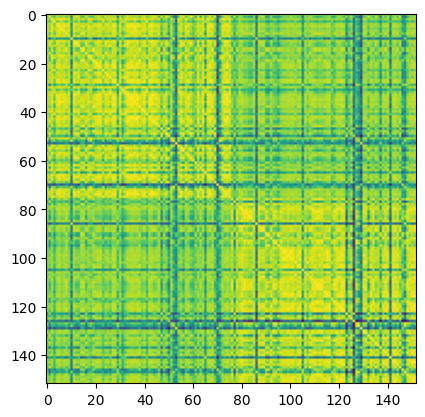

In [21]:
plt.imshow(np.corrcoef(quantum_fidelity_matrix_amp, quantum_fidelity_matrix_amp_qft))

In [22]:
# the proper test for 2 distance matrices is actually Mantel's test.
# we can use this if we have *distance* matrices to measure the correlation (-1 to +1)
# https://fukamilab.github.io/BIO202/06-C-matrix-comparison.html
# says spearman should be use when non-linearity is expected, but idk if we should use that ourselves
# as implemented in skbio, mantel's test requires the diagonals to be 0
from skbio.stats.distance import mantel, pwmantel
# wrapping to fill diagonals to 0
def mantel_test(a, b):
    # a and b should be PD dataframes
    a_np = a.to_numpy() if type(a) is pd.DataFrame else a
    b_np = b.to_numpy() if type(b) is pd.DataFrame else b
    np.fill_diagonal(a_np, 0)  # in-place ops
    np.fill_diagonal(b_np, 0)
    return mantel(a_np, b_np, seed=0)

def pw_mantel_test(dfs):
    # a and b should be PD dataframes
    dfs_np = [d.to_numpy() if type(d) is pd.DataFrame else d for d in dfs]
    for d in dfs_np:
        np.fill_diagonal(d, 0)
    return pwmantel(dfs_np, seed=0)

In [23]:
# not the same
mantel_test(quantum_fidelity_matrix_amp, quantum_fidelity_matrix_amp_qft)

(np.float64(0.7990926015385522), np.float64(0.001), 76)

# plotting

In [24]:
import matplotlib.pyplot as plt

In [25]:
quantum_fidelity_matrix_amp_qft.to_csv(ENV['PWD'] + '/data/quantum_fidelity_amp_qft.csv')

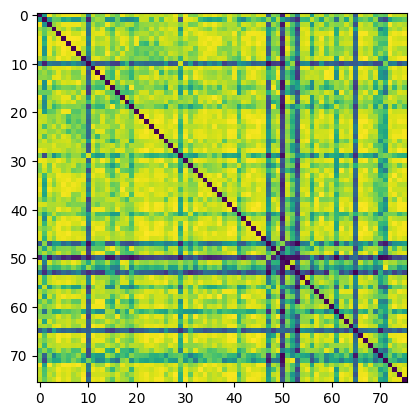

In [26]:
# add colors to plots
quantum_fidelity_matrix = quantum_fidelity_matrix_amp_qft
quantum_fidelity_matrix_np = quantum_fidelity_matrix_amp_qft.to_numpy(dtype=np.float64)
plt.imshow(quantum_fidelity_matrix_np)

In [27]:
# classical euclidean distance
def euclidean(a,b):
    return np.linalg.norm(a-b)

euclidean_distance = pd.DataFrame(columns = ['A', 'B', 'euclidean'])

 # A x B
pairs, pairs_len = combinations(sig_neurons, 2), (len(sig_neurons) * (len(sig_neurons) - 1) // 2)
for a, b in pairs:
    a_i, b_i = resampled_tuning_curves.loc[a], resampled_tuning_curves.loc[b]
    dist = euclidean(a_i, b_i)
    # print(dist)
    euclidean_distance.loc[len(euclidean_distance)] = [a, b, dist]
    euclidean_distance.loc[len(euclidean_distance)] = [b, a, dist]

# # A x A
# # for sanity checking
for a in sig_neurons:
    a_i = resampled_tuning_curves.loc[a]
    dist = euclidean(a_i, a_i)
    euclidean_distance.loc[len(euclidean_distance)] = [a, a, dist]

In [29]:
euclidean_distance_matrix = euclidean_distance.pivot_table(index = 'A', columns = 'B')['euclidean']

In [31]:
euclidean_distance_matrix.to_csv('/home/user/work/quadrigems/data/euclidean_distance.csv')
euclidean_distance_matrix

B,23.0,32.0,35.0,36.0,37.0,50.0,53.0,55.0,57.0,59.0,...,411.0,416.0,419.0,420.0,421.0,424.0,425.0,426.0,428.0,435.0
A,,,,,,,,,,,,,,,,,,,,,
23.0,0.000000,67.192401,18.765622,36.943929,20.420796,13.398795,14.488655,20.059946,27.458729,20.544325,...,16.421985,42.247199,31.964964,26.794152,451.826171,79.604133,13.569228,29.502291,22.911957,26.008402
32.0,67.192401,0.000000,63.222102,49.487140,51.517189,61.252243,65.019070,60.537082,61.940731,54.230464,...,55.720728,47.106849,51.108467,58.607171,442.736740,95.178496,60.551470,52.923664,55.860978,50.537228
35.0,18.765622,63.222102,0.000000,33.413854,22.603101,16.312246,20.712320,18.625860,25.604454,14.721620,...,19.765018,34.846139,30.496417,29.205633,447.499547,78.657388,11.168605,27.685176,18.501035,21.506001
36.0,36.943929,49.487140,33.413854,0.000000,29.148002,37.973924,38.667406,34.153945,38.424935,28.895573,...,33.879329,29.629072,33.999074,40.114624,443.777439,76.953370,32.852051,30.363699,30.415266,22.354609
37.0,20.420796,51.517189,22.603101,29.148002,0.000000,18.159809,23.854127,18.262469,20.815494,14.200901,...,18.446968,26.791937,26.486501,27.185847,441.940939,74.907338,16.893511,19.914243,16.978733,13.083985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424.0,79.604133,95.178496,78.657388,76.953370,74.907338,79.591920,89.596053,64.993711,63.508928,82.598723,...,84.858840,73.534246,81.692503,97.215947,397.742645,0.000000,78.126931,67.266531,80.842099,77.645200
425.0,13.569228,60.551470,11.168605,32.852051,16.893511,10.715781,17.042267,16.132264,20.801712,12.238504,...,16.212104,33.357608,23.095944,25.492371,446.805267,78.126931,0.000000,28.633609,18.058605,19.578865
426.0,29.502291,52.923664,27.685176,30.363699,19.914243,29.175912,34.858003,23.789883,29.805281,25.420280,...,26.405616,31.886097,41.582447,39.825232,439.408090,67.266531,28.633609,0.000000,23.502244,20.485892


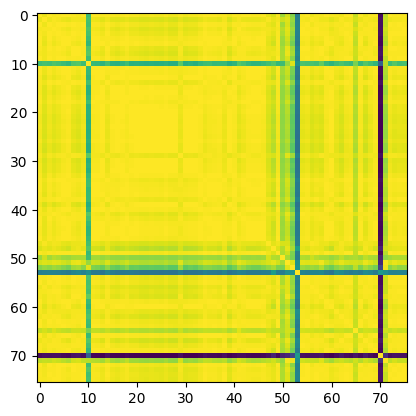

In [32]:
euclidean_distance_matrix_np = euclidean_distance_matrix.corr().to_numpy(dtype=np.float64)
plt.imshow(euclidean_distance_matrix_np)

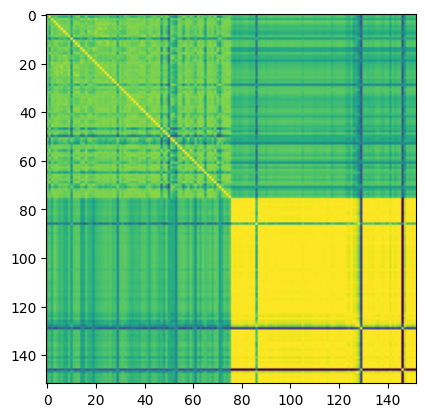

In [33]:
# cross-correlation of fidelity / euclidean distance
# yellow = closer to 1, purple = closer to 0
corr_of_corrs = np.corrcoef(quantum_fidelity_matrix_np, euclidean_distance_matrix_np)
plt.imshow(corr_of_corrs)

In [34]:
# weakly correlated, not the same
mantel_test(quantum_fidelity_matrix_np, euclidean_distance_matrix_np)

(np.float64(0.4605658522623088), np.float64(0.002), 76)

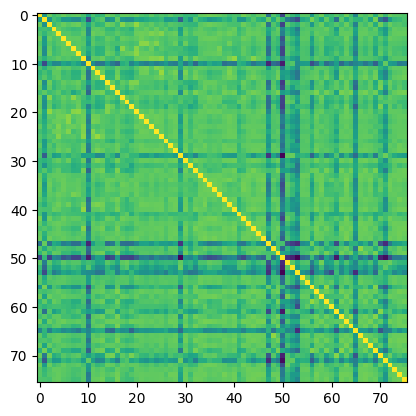

In [35]:
# take the correlation of the fidelity
plt.imshow(quantum_fidelity_matrix.corr().to_numpy(dtype=np.float64))

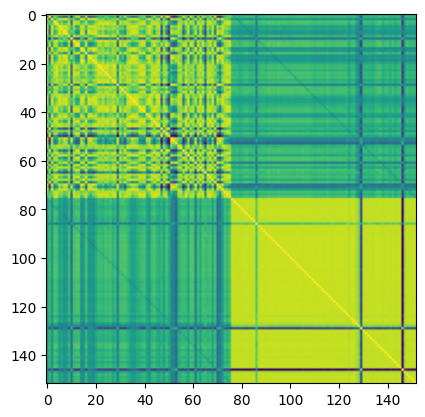

In [36]:
# cross-correlation of fidelity / euclidean distance
# yellow = closer to 1, purple = closer to 0
cross_corr_fidelitycorr_euclidean = np.corrcoef(quantum_fidelity_matrix.corr().to_numpy(dtype=np.float64), euclidean_distance_matrix_np)
plt.imshow(cross_corr_fidelitycorr_euclidean)

In [37]:
# weakly correlated, not the same
mantel_test(quantum_fidelity_matrix.corr().to_numpy(dtype=np.float64), euclidean_distance_matrix_np)

(np.float64(0.34258431514028725), np.float64(0.011), 76)

In [38]:
# kendalltau should not be used
# statistic = how correlated they are (from -1 to +1), pvalue = is it significant?
# scipy.stats.kendalltau(quantum_fidelity_matrix.to_numpy(dtype=np.float64), euclidean_distance_matrix_np)

In [39]:
# is it possible that this is the same result as euclidean distance + qft?
resampled_tuning_curves_ifft = resampled_tuning_curves.apply(lambda x: scipy.fft.ifft(x), axis=1)
resampled_tuning_curves_ifft

23     [(20.95979315745545-0j), (-1.1704352643151612+...
32     [(28.349841888450975-0j), (-0.6445294572317182...
35     [(23.28772728935831-0j), (-1.2082828739655815+...
36     [(26.750994738223646-0j), (0.5442403755661831-...
37     [(23.997053609004013-0j), (-1.522362354942043+...
                             ...                        
424    [(34.70643443629844-0j), (-2.2350738112130912+...
425    [(22.52649690418081-0j), (-1.8998904191559198+...
426    [(26.37806395919683-0j), (0.323746363099059+1....
428    [(25.062008611317356-0j), (-1.751304856615366-...
435    [(25.218372381714577-0j), (-0.6726040584625275...
Length: 76, dtype: object

In [40]:
# classical euclidean distance
def euclidean(a,b):
    return np.linalg.norm(a-b)

euclidean_distance_ifft = pd.DataFrame(columns = ['A', 'B', 'euclidean'])

 # A x B
pairs, pairs_len = combinations(sig_neurons, 2), (len(sig_neurons) * (len(sig_neurons) - 1) // 2)
for a, b in pairs:
    a_i, b_i = resampled_tuning_curves_ifft.loc[a], resampled_tuning_curves_ifft.loc[b]
    dist = euclidean(a_i, b_i)
    # print(dist)
    euclidean_distance_ifft.loc[len(euclidean_distance_ifft)] = [a, b, dist]
    euclidean_distance_ifft.loc[len(euclidean_distance_ifft)] = [b, a, dist]

# # A x A
# # for sanity checking
for a in sig_neurons:
    a_i = resampled_tuning_curves.loc[a]
    dist = euclidean(a_i, a_i)
    euclidean_distance_ifft.loc[len(euclidean_distance_ifft)] = [a, a, dist]

In [41]:
euclidean_distance_ifft_matrix =  euclidean_distance_ifft.pivot_table(index = 'A', columns = 'B')['euclidean']

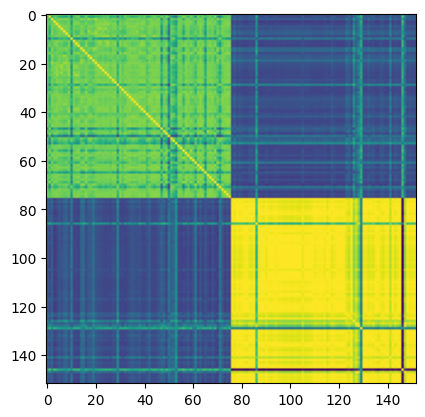

In [42]:
# cross-correlation of fidelity / euclidean distance
# yellow = closer to 1, purple = closer to 0
plt.imshow(np.corrcoef(quantum_fidelity_matrix_np, euclidean_distance_ifft_matrix))

In [43]:
# this is more correlated but not the same
mantel_test(quantum_fidelity_matrix_np, euclidean_distance_ifft_matrix)

(np.float64(-0.5717013109756286), np.float64(0.001), 76)

# Probability distribution analysis

Starting with just the mean first

In [ ]:
plt.imshow(quantum_mean_matrix.to_numpy(dtype=np.float64))

In [ ]:
plt.imshow(quantum_mean_matrix.corr().to_numpy(dtype=np.float64))

In [ ]:
# cross-correlation of fidelity / euclidean distance
# yellow = closer to 1, purple = closer to 0
corr_of_corrs = np.corrcoef(quantum_mean_matrix.corr().to_numpy(dtype=np.float64), euclidean_distance_matrix_np)
plt.imshow(corr_of_corrs)

In [ ]:
# not very corrrelated
scipy.stats.kendalltau(quantum_mean_matrix.corr().to_numpy(dtype=np.float64), euclidean_distance_matrix_np)

In [ ]:
# not very corrrelated
scipy.stats.spearmanr(quantum_mean_matrix.corr().to_numpy(dtype=np.float64), euclidean_distance_matrix_np).statistic

In [ ]:
# compared to original data?
corrs = tuning_curves.T.corr().to_numpy()
plt.imshow(corrs)

In [ ]:
plt.imshow(np.corrcoef(quantum_mean_matrix.corr().to_numpy(dtype=np.float64), corrs))
scipy.stats.kendalltau(quantum_mean_matrix.corr().to_numpy(dtype=np.float64), corrs)

In [ ]:
# the proper test for 2 distance matrices is actually Mantel's test
# https://fukamilab.github.io/BIO202/06-C-matrix-comparison.html
# says spearman should be use when non-linearity is expected
# as implemented in skbio, mantel's test requires the diagnoals to be 0
from skbio.stats.distance import mantel, pwmantel
np.fill_diagonal(quantum_mean_matrix.to_numpy(dtype=np.float64), 0)
np.fill_diagonal(euclidean_distance_matrix_np, 0)
# corr_coeff, p, n_values
mantel(quantum_mean_matrix, euclidean_distance_matrix_np, seed=0)

In [ ]:
pwmantel(dms = [quantum_mean_matrix, quantum_fidelity_matrix_np, euclidean_distance_matrix_np], labels=['mean probability', 'fidelity', 'euclidean distance'])

# weight histogram analysis

In [ ]:
_ = plt.hist(q_fidelity_corr)
_ = plt.title('Angle Encoding → QFT → SWAP → Overlap')

In [ ]:
plt.violinplot(q_fidelity_corr.reshape((q_fidelity_corr.size,)), orientation='horizontal', showmeans=True)

In [ ]:
_ = plt.hist(q_mean_corr)
_ = plt.title('Angle Encoding → QFT → SWAP → Overlap (mean probability')

In [ ]:
plt.violinplot(q_fidelity_corr.reshape((q_fidelity_corr.size,)), orientation='horizontal', showmeans=True)

similar distributions? with harmonic-ish stuff in research
- [superoscillations](https://www.semanticscholar.org/paper/Super-oscillation-by-higher-order-radially-beams-Matsunaga-Kozawa/0784f24ec848c9e2fa002c7806de992859977ee1)
- [higher-order gaussian](https://www.researchgate.net/figure/The-normalized-intensity-distribution-of-hollow-higher-order-cosh-Gaussian-beams-at-the_fig1_347963556)

# summary

- quantum state fidelity is highly correlated with euclidean distance
- using sigmoid may not help
- removing / adding Hs to the canonical swap produces uncorrelated value
- Taking the mean of the probability of the bitstrings can also produce an uncorrelated value
- kendalltau can show correlation

# TODO

- run on QPU (no mitigation)
- run on QPU (with Mitiq)
- end to end analysis